# 03 Model Response Curves
Learn per-channel spend → conversions relationships using:
- Linear Regression (baseline, interpretable)
- Boosted Trees (HistGradientBoostingRegressor; XGBoost if available)

We’ll export smooth response curves per channel for optimization in Part 5.

In [47]:
# 03 Model Response Curves (with smoothing & version-proof metrics)
# Learns per-channel Spend -> Conversions curves using Linear Regression and XGBoost.
# Exports smoothed curves for the optimizer in Part-5.
# Outputs:
#   ../data/processed/response_curves/<channel>_response_curve.csv
#   ../data/processed/model_response_summary.csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

from scipy.signal import savgol_filter

np.set_printoptions(suppress=True)
pd.set_option("display.float_format", "{:,.4f}".format)

DATA_PATH = Path("../data/processed/campaign_daily_processed.csv")
OUT_DIR   = Path("../data/processed/response_curves")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42

In [48]:
df = pd.read_csv(DATA_PATH, parse_dates=["date"])
required = {"date","channel","spend","conversions","is_weekend"}
missing = required - set(df.columns)
assert not missing, f"Missing columns in {DATA_PATH}: {missing}"

df = df.sort_values(["channel","date"]).reset_index(drop=True)
channels = df["channel"].unique().tolist()
print("Channels:", channels)
df.head()

Channels: ['Display', 'LinearTV', 'Social', 'Streaming', 'YouTube']


,date,channel,spend,cpm,impressions,clicks,conversions,est_reach,dow,is_weekend,reach_pct,reach_people
0,2024-01-01,Display,"17,034.6002",9.0000,"1,892,733.3515","35,378.4065",16.7301,"181,040.4649",0,0,0.1380,"137,951.7804"
1,2024-01-02,Display,"12,958.5648",9.0000,"1,439,840.5314","28,533.9077",12.0974,"141,685.1034",1,0,0.1073,"107,278.7549"
2,2024-01-03,Display,"15,738.2296",9.0000,"1,748,692.1816","36,805.4142",19.1302,"168,773.9805",2,0,0.1283,"128,346.5491"
3,2024-01-04,Display,"18,866.2482",9.0000,"2,096,249.8010","44,912.7998",15.6756,"197,984.9377",3,0,0.1513,"151,289.3694"
4,2024-01-05,Display,"12,580.8009",9.0000,"1,397,866.7689","28,388.3472",24.0409,"137,918.9861",4,0,0.1044,"104,365.0325"


In [49]:
def make_features(frame: pd.DataFrame) -> pd.DataFrame:
    X = frame.copy()
    X["log_spend"] = np.log1p(X["spend"])
    X["sqrt_spend"] = np.sqrt(X["spend"])
    if "month" not in X:
        X["month"] = pd.to_datetime(X["date"]).dt.month
    return X[["log_spend","sqrt_spend","month","is_weekend"]]

def evaluate(y_true, y_pred) -> dict:
    # Robust to older sklearn: RMSE computed manually
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)   # default squared=True
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

In [50]:
def smooth_series(y, max_window=21, poly=2):
    """
    Savitzky–Golay smoothing with safe window selection:
    - window odd
    - window >= 5
    - window <= len(y)
    Falls back to raw y if too short.
    """
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n < 5:
        return y
    w = min(max_window, n)
    if w % 2 == 0:  # must be odd
        w -= 1
    if w < 5:
        # last-resort odd <= n
        w = n if n % 2 == 1 else n-1
        if w < 5:
            return y
    return savgol_filter(y, w, poly, mode="nearest")

In [51]:
models = {}           # <- will contain only successfully trained channels
trained_channels = []
failed = []

for ch in sorted(df['channel'].unique()):
    try:
        sub = df[df["channel"] == ch].copy().sort_values("date").reset_index(drop=True)

        # Basic sanity
        if len(sub) < 20:
            raise ValueError(f"Not enough rows for {ch}: {len(sub)}")

        # time-aware split
        n = len(sub)
        cut = max(10, int(n * 0.8))  # ensure reasonable train size
        train, test = sub.iloc[:cut].copy(), sub.iloc[cut:].copy()

        X_train, y_train = make_features(train), train["conversions"].astype(float)
        X_test,  y_test  = make_features(test),  test["conversions"].astype(float)

        # Check for NaNs/inf
        if X_train.isna().any().any() or np.isinf(X_train.values).any():
            raise ValueError(f"NaNs/inf in features for {ch}")

        # --- Linear Regression ---
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred_lr_test = lr.predict(X_test)

        # --- XGBoost ---
        xgb = XGBRegressor(
            n_estimators=500,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        xgb.fit(X_train, y_train)
        y_pred_xgb_test = xgb.predict(X_test)

        # Metrics
        m_lr  = evaluate(y_test,  y_pred_lr_test)
        m_xgb = evaluate(y_test, y_pred_xgb_test)
        print(f"{ch:10s}  LR RMSE={m_lr['RMSE']:.3f}  XGB RMSE={m_xgb['RMSE']:.3f}")

        # Spend grid — guard degenerate ranges
        smin, smax = float(sub["spend"].min()), float(sub["spend"].max())
        if not np.isfinite(smin) or not np.isfinite(smax) or smax <= smin:
            mu = float(sub["spend"].mean())
            smin, smax = max(1.0, 0.5*mu), max(2.0, 1.5*mu)

        grid = np.linspace(smin, smax, max(51, min(401, len(sub))))  # enough points, but bounded
        grid_df = pd.DataFrame({
            "date": pd.Timestamp("2024-06-15"),
            "spend": grid,
            "is_weekend": 0
        })
        Xg = make_features(grid_df)

        pred_lr  = np.clip(lr.predict(Xg),  0, None)
        pred_xgb = np.clip(xgb.predict(Xg), 0, None)

        # Smooth
        pred_lr_smooth  = smooth_series(pred_lr)
        pred_xgb_smooth = smooth_series(pred_xgb)

        # Export
        snake = ch.lower().replace(" ", "").replace("-", "")
        out = pd.DataFrame({
            "spend": grid.astype(float),
            "pred_conversions_xgb": pred_xgb_smooth.astype(float),
            "pred_conversions_lr":  pred_lr_smooth.astype(float)
        }).sort_values("spend").drop_duplicates(subset=["spend"])

        if len(out) < 2 or not np.isfinite(out.values).all():
            raise ValueError(f"Predictions invalid for {ch}")

        out.to_csv(OUT_DIR / f"{snake}_response_curve.csv", index=False)

        # Save models + metrics for plotting later
        models[ch] = {"lr": lr, "xgb": xgb, "metrics": {"lr": m_lr, "xgb": m_xgb}, "grid": grid, "curve": out}
        trained_channels.append(ch)

    except Exception as e:
        failed.append((ch, str(e)))
        print(f"Skipping {ch}: {e}")

print("\nTrained channels:", trained_channels)
if failed:
    print("Failed channels:")
    for ch, msg in failed:
        print(f"  - {ch}: {msg}")

Display     LR RMSE=4.381  XGB RMSE=5.758
LinearTV    LR RMSE=7.953  XGB RMSE=9.211
Social      LR RMSE=5.497  XGB RMSE=6.694
Streaming   LR RMSE=6.057  XGB RMSE=7.285
YouTube     LR RMSE=5.016  XGB RMSE=5.735

Trained channels: ['Display', 'LinearTV', 'Social', 'Streaming', 'YouTube']


In [52]:
import sys, inspect, sklearn
print("Python:", sys.executable)
print("sklearn:", sklearn.__version__)
print("inspect:", inspect.__file__)

Python: /Users/aravindanisetti/Desktop/2025 Training/Projects/.venv/bin/python
sklearn: 1.7.2
inspect: /usr/local/Cellar/python@3.11/3.11.14/Frameworks/Python.framework/Versions/3.11/lib/python3.11/inspect.py


In [53]:
def plot_response_curve(channel, month=6, is_weekend=0, num=200):
    if channel not in models:
        print(f"Channel '{channel}' not trained. Available:", list(models.keys()))
        return
    sub = df[df["channel"] == channel].copy().sort_values("date")
    spend_grid = np.linspace(sub["spend"].min(), sub["spend"].max(), num)
    X_seq = pd.DataFrame({
        "date": pd.Timestamp("2024-06-15"),
        "spend": spend_grid,
        "is_weekend": is_weekend
    })
    X_seq = make_features(X_seq)

    lr = models[channel]["lr"]
    xgb = models[channel]["xgb"]

    y_lr  = smooth_series(np.clip(lr.predict(X_seq),  0, None))
    y_xgb = smooth_series(np.clip(xgb.predict(X_seq), 0, None))

    plt.figure(figsize=(7,4))
    plt.scatter(sub["spend"], sub["conversions"], s=8, alpha=0.35, label="Actual (daily)")
    plt.plot(spend_grid, y_lr,  label="LR (smoothed)")
    plt.plot(spend_grid, y_xgb, label="XGB (smoothed)")
    plt.title(f"Response Curve — {channel}")
    plt.xlabel("Spend ($)"); plt.ylabel("Predicted Conversions")
    plt.legend(); plt.tight_layout(); plt.show()


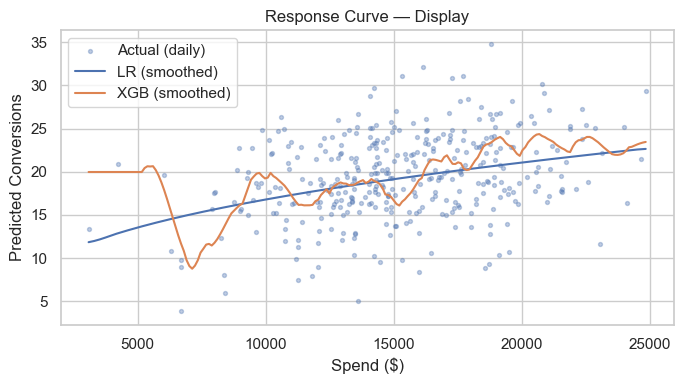

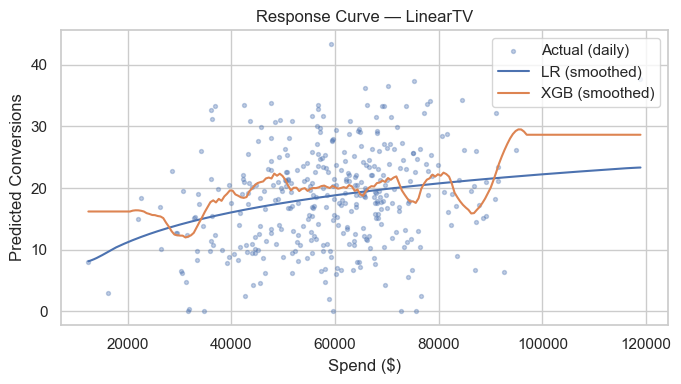

In [54]:
# Example: plot the first two trained channels
for ch in list(models.keys())[:2]:
    plot_response_curve(ch)

In [55]:
summary_rows = []
for ch, pack in models.items():
    m_lr = pack["metrics"]["lr"]
    m_xgb = pack["metrics"]["xgb"]
    summary_rows.append([ch, m_lr["RMSE"], m_lr["MAE"], m_lr["R2"],
                             m_xgb["RMSE"], m_xgb["MAE"], m_xgb["R2"]])

summary = pd.DataFrame(summary_rows, columns=[
    "channel","LR_RMSE","LR_MAE","LR_R2","XGB_RMSE","XGB_MAE","XGB_R2"
]).sort_values("XGB_RMSE")
summary_path = Path("../data/processed/model_response_summary.csv")
summary.to_csv(summary_path, index=False)
print("Saved summary:", summary_path)
summary

Saved summary: ../data/processed/model_response_summary.csv


,channel,LR_RMSE,LR_MAE,LR_R2,XGB_RMSE,XGB_MAE,XGB_R2
4,YouTube,5.0159,4.1003,0.2090,5.7350,4.4829,-0.0340
0,Display,4.3810,3.5955,0.0933,5.7577,4.5571,-0.5661
2,Social,5.4973,4.3578,-0.1716,6.6938,5.3349,-0.7371
3,Streaming,6.0571,4.7619,-0.0245,7.2852,5.8332,-0.4820
1,LinearTV,7.9528,6.4661,0.0814,9.2114,7.3116,-0.2324


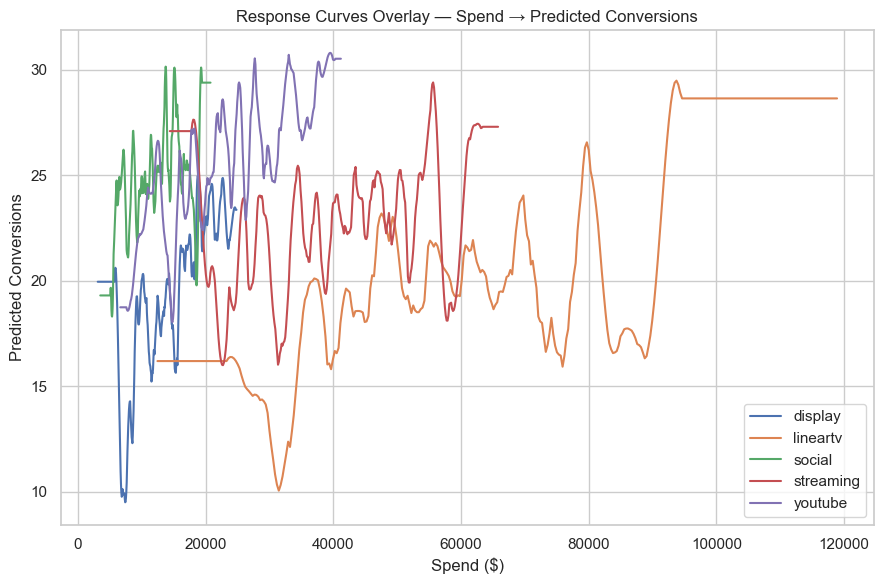

In [56]:
from pathlib import Path

curve_dir = OUT_DIR
files = sorted(curve_dir.glob("*_response_curve.csv"))

plt.figure(figsize=(9,6))
for f in files:
    ch = f.name.replace("_response_curve.csv","")
    dfc = pd.read_csv(f)
    # prefer boosted column if present
    if "pred_conversions_xgb" in dfc.columns:
        y = dfc["pred_conversions_xgb"]
    elif "pred_conversions_lr" in dfc.columns:
        y = dfc["pred_conversions_lr"]
    else:
        # first numeric col other than spend
        cols = [c for c in dfc.select_dtypes(include=[np.number]).columns if c != "spend"]
        y = dfc[cols[0]]
    plt.plot(dfc["spend"], y, label=ch)

plt.title("Response Curves Overlay — Spend → Predicted Conversions")
plt.xlabel("Spend ($)"); plt.ylabel("Predicted Conversions")
plt.legend(); plt.tight_layout(); plt.show()


In [57]:
print("Channels present in data:", sorted(df['channel'].unique().tolist()))
print("\nRow counts per channel:")
print(df.groupby('channel').size().sort_values())

print("\nNull check (should be 0):")
print(df[['date','channel','spend','conversions','is_weekend']].isna().sum())

print("\nSpend summary by channel (min should be < max):")
print(df.groupby('channel')['spend'].agg(['min','max','mean','std']))


Channels present in data: ['Display', 'LinearTV', 'Social', 'Streaming', 'YouTube']

Row counts per channel:
channel
Display      365
LinearTV     365
Social       365
Streaming    365
YouTube      365
dtype: int64

Null check (should be 0):
date           0
channel        0
spend          0
conversions    0
is_weekend     0
dtype: int64

Spend summary by channel (min should be < max):
                  min          max        mean         std
channel                                                   
Display    3,087.3607  24,827.9741 15,275.4237  3,731.4535
LinearTV  12,443.6140 118,893.5656 58,973.8090 15,077.2301
Social     3,487.4807  20,754.5207 11,970.6781  2,992.4274
Streaming 14,376.6634  65,797.0934 40,018.9346  9,297.5735
YouTube    6,622.5710  41,174.4311 24,662.1310  6,318.0269
